In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
nltk.download('stopwords')



/var/folders/2d/3hctyjd51cn5wc76s6w7g2d00000gn/T/ipykernel_7324/1998152382.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuelamiranda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Creation of Affinities

In [2]:
df = pd.read_csv('../datasets/user_song_df2.csv')

In [3]:
df.columns

Index(['user_id', 'track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_album_release_year',
       'duration_minutes', 'track_name_preprocessed',
       'playlist_name_sentiment', 'track_name_sentiment', 'cluster'],
      dtype='object')

In [4]:
df.head()

,user_id,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_name,playlist_id,playlist_genre,...,instrumentalness,liveness,valence,tempo,track_album_release_year,duration_minutes,track_name_preprocessed,playlist_name_sentiment,track_name_sentiment,cluster
0,0,6F5c58TMEs1byxUstkzVeM,Roar,4897,77,5MQBzs5YlZlE28mD9yUItn,12217,top hits,2DjIfVDXGYDgRxw7IJTKVb,0,...,0.000007,0.3540,0.455,179.984,2013,3.73,roar,0.5,0.0,1
1,0,2gT8OWcAgPg0yawg1qw4Nv,Loma de Cayenas,9965,51,7gSN3OHB6q52ivR61esxSe,2889,paraiso tropical,37i9dQZF1DWYey22ryYM8U,1,...,0.000000,0.0969,0.964,129.955,2019,3.80,loma de cayenas,0.0,0.0,19
2,0,24b20V609aI0WJ8LyxR8qx,The Game & Skrillex: El Chapo,9286,60,19tRwHQ4ZoKnwa1S8zB041,16308,rap gangsta,1Z1gW89x4MSBjkvVjGg7DQ,4,...,0.000000,0.2810,0.591,126.994,2015,3.67,game skrillex el chapo,0.0,-0.4,19
3,0,6wyr4ReB05D9sJB1Rsmcqo,Chicken Noodle Soup (feat. Becky G),10569,76,76IRLp7YzBVLKsat6Ro9ae,3141,indie,6MQeEHHDs6HQkN5Dlj3oKo,2,...,0.000011,0.2940,0.168,97.053,2019,3.92,chicken noodle soup feat becky g,0.0,-0.6,19
4,0,1hZJcuz9iMoz6tLkFlIaUy,Take My Breath Away,1005,60,1gwQ8OK1YHKpzIxLKuc1MQ,15747,songs top music hits,65HtIbyFkaQPflCa4oW8KO,2,...,0.000310,0.1240,0.511,95.892,2007,4.40,take breath away,0.5,0.0,13


Scaling, dimensionality reduction and calculation of affinities

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Convert all column names to string
df.columns = df.columns.astype(str)

df_features = df.select_dtypes(exclude=['object'])

# Scale the features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_features.columns)

# Add user_id back for grouping
df_scaled['user_id'] = df['user_id']

# Convert all column names to string
df_scaled.columns = df_scaled.columns.astype(str)

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled.drop('user_id', axis=1))
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'], index=df.index)
df_pca['user_id'] = df['user_id']

# Calculate user centroids in the PCA-reduced space
user_centroids_pca = df_pca.groupby('user_id')[['PC1', 'PC2']].mean()

# Re-define the function to calculate affinity score based on Euclidean distance in the reduced space
def calculate_affinity(user_id, song_features):
    user_centroid = user_centroids_pca.loc[user_id]
    distance = euclidean(user_centroid, song_features)
    affinity = 1 / (1 + distance)  # Inverse distance as affinity
    return affinity


# Calculate affinity scores for each song to its user in the reduced space
df['affinity_score'] = df_pca.apply(lambda row: calculate_affinity(row['user_id'], row[['PC1', 'PC2']]), axis=1)
print(df['affinity_score'].head())

0    0.548723
1    0.634774
2    0.740817
3    0.775286
4    0.775706
Name: affinity_score, dtype: float64


/var/folders/2d/3hctyjd51cn5wc76s6w7g2d00000gn/T/ipykernel_7324/2926932948.py:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id} Centroid')


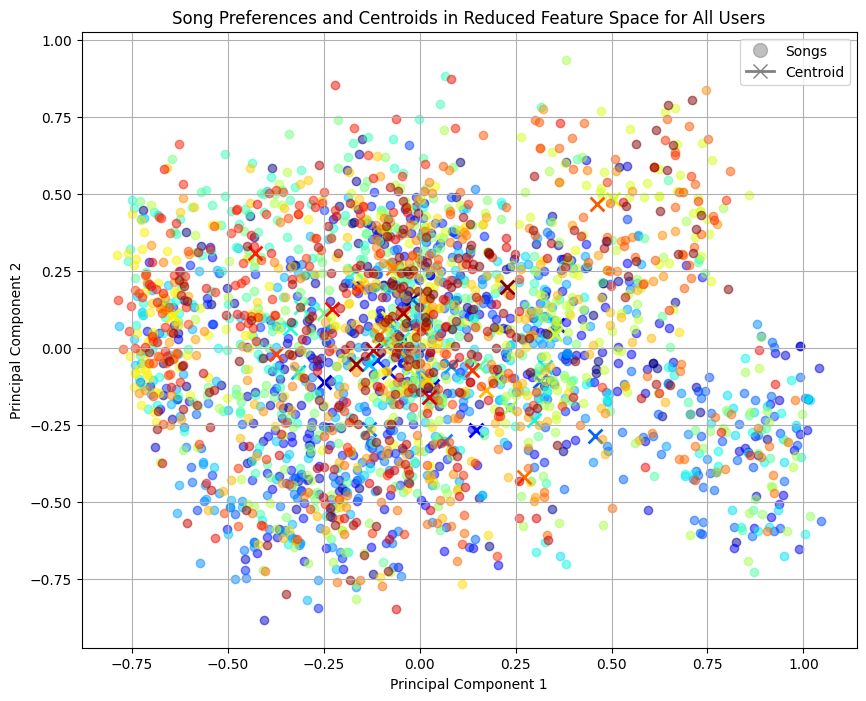

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the rest of your code is unchanged and correct up to this point

# Generate a color map for each user
unique_users = df_pca['user_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_users)))
user_color_map = {user_id: color for user_id, color in zip(unique_users, colors)}

plt.figure(figsize=(10, 8))

# Plot songs and centroids for all users on the same plot
for user_id, color in user_color_map.items():
    # Plot songs for each user
    user_songs = df_pca[df_pca['user_id'] == user_id]
    plt.scatter(user_songs['PC1'], user_songs['PC2'], color=color, alpha=0.5, label=f'User {user_id} Songs')
    
    # Plot user centroid
    centroid = user_centroids_pca.loc[user_id]
    plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id} Centroid')

# Because we have many legends (each user + their centroid), let's simplify the legend
# Create custom legends
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=0, marker='o', markersize=10, alpha=0.5, label='Songs'),
                Line2D([0], [0], color='gray', marker='x', markersize=10, lw=2, label='Centroid')]
plt.legend(custom_lines, ['Songs', 'Centroid'])

plt.title('Song Preferences and Centroids in Reduced Feature Space for All Users')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


/var/folders/2d/3hctyjd51cn5wc76s6w7g2d00000gn/T/ipykernel_7324/1288268535.py:12: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id}')


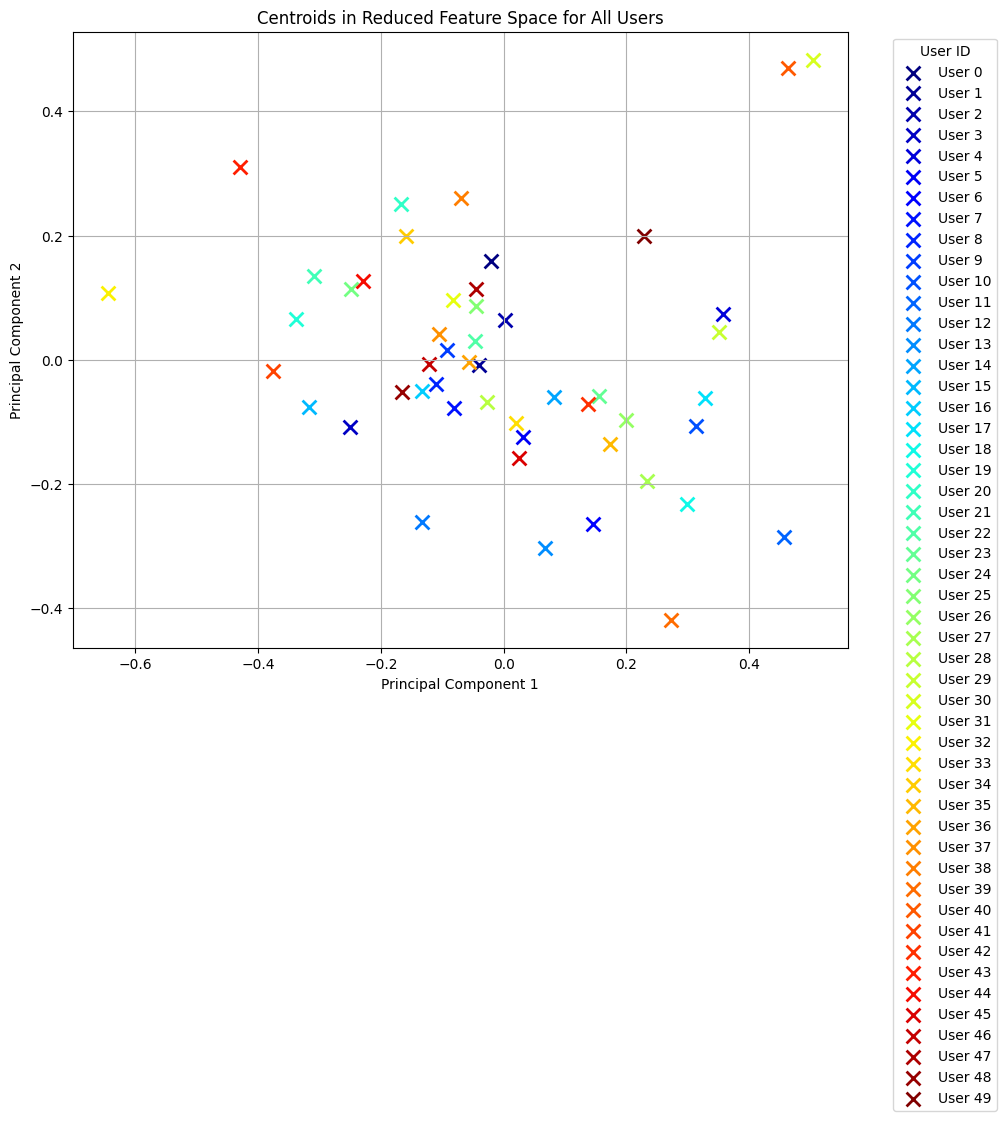

In [12]:
# Generate a color map for each user
unique_users = df_pca['user_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_users)))
user_color_map = {user_id: color for user_id, color in zip(unique_users, colors)}

plt.figure(figsize=(10, 8))

# Plot centroids for all users
for user_id, color in user_color_map.items():
    # Retrieve user centroid
    centroid = user_centroids_pca.loc[user_id]
    plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id}')

plt.title('Centroids in Reduced Feature Space for All Users')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="User ID", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement to avoid overlap
plt.grid(True)
plt.show()


In [13]:
df.to_csv('../datasets/user_song_affinities_df2.csv', index=False)